# Burgers Equation UPINN

In [1]:
import torch
import sys
from scipy.stats import qmc # For hypercube sampling
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# Set the seed for reproducibility
torch.manual_seed(42)

# Add the parent directory of the script (i.e., project/) to sys.path
sys.path.append('../utils')
from UPINN import UPINN
from Architectures import FNN
from Utils import RAD_sampler

Consider Burgers equation:

\begin{align}
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
\end{align}

where $u(x,t)$ is the velocity field, $\nu$ is the viscosity coefficient, $x \in [-1,1]$ and $t \in [0,1]$. The initial condition is $u(x,0) = -\sin(\pi x)$ and the boundary conditions are $u(-1,t) = u(1,t) = 0$.

### Setup Boundary Value Problem

In [2]:
# Initial condition
N_ic = 100
u0 = lambda x: -torch.sin(torch.pi * x)
x0 = torch.linspace(-1, 1, N_ic)
t0 = torch.zeros_like(x0)
X0 = torch.stack((t0, x0), dim=-1)
U0 = u0(x0).reshape(-1, 1)

In [3]:
# Boundary condition
N_bc = 100
uL = lambda t: torch.zeros_like(t)
uR = lambda t: torch.zeros_like(t)
tL = torch.linspace(0, 1, N_bc)
tR = torch.linspace(0, 1, N_bc)
xL = -torch.ones_like(tL)
xR = torch.ones_like(tR)
XL = torch.stack((tL, xL), dim=-1)
XR = torch.stack((tR, xR), dim=-1)
Xbc = torch.cat((XL, XR), dim=0)
Ubc = torch.cat((uL(tL).reshape(-1, 1), uR(tR).reshape(-1, 1)), dim=0)

In [4]:
# Collocation points
N_coll = 10000
sobol = torch.quasirandom.SobolEngine(dimension=2)
Xc = sobol.draw(n=N_coll, dtype=torch.float32)
Xc[:, 1] = Xc[:, 1]*2 - 1

In [5]:
# Data points
burger_data = np.load('../data/Burgers.npz')
td = torch.tensor(burger_data['t'], dtype=torch.float32)
xd = torch.tensor(burger_data['x'], dtype=torch.float32)
Td, Xd = torch.meshgrid(td.squeeze(), xd.squeeze())
Xd = torch.stack((Td.flatten(), Xd.flatten()), dim=-1)
Ud = torch.tensor(burger_data['usol'].T.flatten(), dtype=torch.float32).reshape(-1, 1)

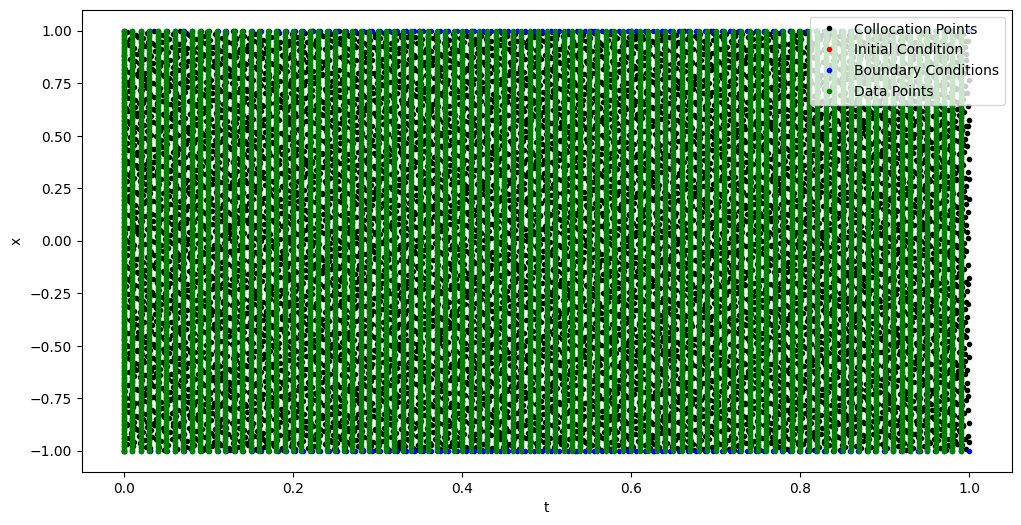

In [6]:
# Plot the initial condition, boundary conditions, and collocation points
plt.figure(figsize=(12, 6))
plt.plot(Xc[:, 0], Xc[:, 1], 'k.', label='Collocation Points')
plt.plot(X0[:, 0], X0[:, 1], 'r.', label='Initial Condition')
plt.plot(Xbc[:, 0], Xbc[:, 1], 'b.', label='Boundary Conditions')
plt.plot(Xd[:, 0], Xd[:, 1], 'g.', label='Data Points')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()
plt.show()

### Setup Boundary Value Problem

In [7]:
class Burger(torch.nn.Module):
    def __init__(self, nu):
        super(Burger, self).__init__()
        self.nu = nu
    
    def forward(self, X, u):

        dudxt = torch.autograd.grad(u, X, torch.ones_like(u), create_graph=True)[0]
        u_t = dudxt[:,0:1]
        u_x = dudxt[:,1:2]
        
        u_xx = torch.autograd.grad(dudxt, X, torch.ones_like(dudxt), create_graph=True)[0][:,1:2]

        return u_t + u*u_x - self.nu*u_xx


class SparseBurger(torch.nn.Module):
    def __init__(self, nu):
        super(SparseBurger, self).__init__()
        self.nu = nu
    
    def forward(self, X, u):

        dudxt = torch.autograd.grad(u, X, torch.ones_like(u), create_graph=True)[0]
        u_t = dudxt[:,0:1]
        
        u_xx = torch.autograd.grad(dudxt, X, torch.ones_like(dudxt), create_graph=True)[0][:,1:2]

        return u_t - self.nu*u_xx

### Initialize and train UPINN

In [8]:
class UPINN(UPINN):

    def refine_collocation_points(self):
        N = 100000
        D = 2000
        k = 0.5
        c = 0.1

        Xc = sobol.draw(n=N_coll, dtype=torch.float32)
        Xc[:, 1] = Xc[:, 1]*2 - 1
        Xc.requires_grad_(True)

        # Compute the residual
        u = self.u(Xc)
        residual = abs(self.F(Xc, u) + self.G(torch.cat([Xc, u], dim=1)))
        
        self.collocation_points = RAD_sampler(Xc, residual, D, k, c)

In [9]:
# Define model architectures
hidden = [64] * 3
u = FNN(
    dims=[2, *hidden, 1],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.Identity(),
)
G = FNN(
    dims=[3, *hidden, 1],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.Identity(),
)

nu = 0.01/torch.pi
F = SparseBurger(nu)

# Instantiate the UPINN
upinn = UPINN(u, F, G, initial_points=(X0, U0), boundary_points=(Xbc, Ubc), data_points=(Xd, Ud), collocation_points=Xc)

[Info]: Initializing UPINN model


In [10]:
for _ in range(50):
    upinn.train_loop(epochs=1000, optimizer=torch.optim.Adam, optimizer_kwargs=dict(lr=1e-3))
    upinn.train_loop(epochs=1000, optimizer=torch.optim.LBFGS, optimizer_kwargs=dict(max_iter=1))
    upinn.refine_collocation_points()

[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:12<00:00, 77.03 epoch/s, L=7.46e-03, L_ic=3.35e-03, L_bc=4.54e-04, L_data=2.21e-02, L_pde=3.95e-03]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:39<00:00, 25.17 epoch/s, L=5.65e-04, L_ic=6.49e-05, L_bc=7.73e-06, L_data=1.80e-03, L_pde=3.87e-04]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:12<00:00, 78.35 epoch/s, L=2.50e-03, L_ic=2.87e-04, L_bc=8.44e-05, L_data=2.11e-03, L_pde=7.51e-03]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:41<00:00, 24.11 epoch/s, L=3.04e-04, L_ic=2.30e-05, L_bc=3.24e-06, L_data=1.01e-03, L_pde=1.80e-04]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:12<00:00, 80.48 epoch/s, L=4.29e-04, L_ic=2.85e-05, L_bc=3.41e-06, L_data=1.09e-03, L_pde=5.95e-04]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:39<00:00, 25.44 epoch/s, L=2.20e-04, L_ic=2.45e-05, L_bc=1.64e-06, L_data=7.27e-04, L_pde=1.27e-04]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:12<00:00, 82.14 epoch/s, L=2.26e-04, L_ic=2.78e-05, L_bc=1.42e-06, L_data=7.54e-04, L_pde=1.21e-04]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:39<00:00, 25.59 epoch/s, L=1.64e-04, L_ic=2.28e-05, L_bc=1.07e-06, L_data=5.46e-04, L_pde=8.78e-05]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:13<00:00, 71.56 epoch/s, L=5.85e-04, L_ic=4.92e-05, L_bc=9.82e-06, L_data=6.73e-04, L_pde=1.61e-03]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:39<00:00, 25.41 epoch/s, L=1.39e-04, L_ic=1.43e-05, L_bc=1.10e-06, L_data=4.75e-04, L_pde=6.47e-05]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:12<00:00, 81.78 epoch/s, L=1.54e-04, L_ic=1.24e-05, L_bc=1.16e-06, L_data=5.07e-04, L_pde=9.43e-05]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:39<00:00, 25.30 epoch/s, L=1.17e-04, L_ic=1.23e-05, L_bc=8.76e-07, L_data=3.95e-04, L_pde=5.87e-05]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:12<00:00, 83.25 epoch/s, L=2.16e-04, L_ic=2.08e-05, L_bc=4.48e-06, L_data=5.52e-04, L_pde=2.88e-04]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:38<00:00, 25.64 epoch/s, L=1.04e-04, L_ic=7.54e-06, L_bc=4.81e-07, L_data=3.63e-04, L_pde=4.42e-05]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:12<00:00, 82.69 epoch/s, L=1.33e-04, L_ic=1.36e-05, L_bc=1.09e-06, L_data=3.94e-04, L_pde=1.24e-04]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:40<00:00, 24.72 epoch/s, L=1.01e-04, L_ic=6.25e-06, L_bc=6.08e-07, L_data=3.51e-04, L_pde=4.56e-05]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:12<00:00, 82.57 epoch/s, L=1.16e-04, L_ic=7.80e-06, L_bc=1.02e-06, L_data=3.73e-04, L_pde=8.29e-05]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:12<00:00, 77.70 epoch/s, L=1.16e-04, L_ic=7.80e-06, L_bc=1.02e-06, L_data=3.73e-04, L_pde=8.29e-05]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:12<00:00, 80.79 epoch/s, L=1.36e-04, L_ic=9.13e-06, L_bc=1.30e-06, L_data=4.13e-04, L_pde=1.20e-04]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:38<00:00, 25.75 epoch/s, L=9.33e-05, L_ic=6.78e-06, L_bc=1.20e-06, L_data=3.20e-04, L_pde=4.52e-05]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:12<00:00, 82.35 epoch/s, L=1.07e-04, L_ic=7.70e-06, L_bc=1.58e-06, L_data=3.38e-04, L_pde=7.84e-05]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:13<00:00, 76.51 epoch/s, L=1.07e-04, L_ic=7.69e-06, L_bc=1.58e-06, L_data=3.38e-04, L_pde=7.84e-05]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:12<00:00, 82.81 epoch/s, L=1.12e-04, L_ic=1.08e-05, L_bc=1.84e-06, L_data=3.64e-04, L_pde=7.04e-05]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:14<00:00, 70.45 epoch/s, L=1.12e-04, L_ic=1.08e-05, L_bc=1.84e-06, L_data=3.64e-04, L_pde=7.03e-05]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:12<00:00, 80.71 epoch/s, L=1.19e-04, L_ic=9.80e-06, L_bc=1.63e-06, L_data=3.76e-04, L_pde=8.69e-05]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:39<00:00, 25.39 epoch/s, L=8.61e-05, L_ic=3.74e-06, L_bc=4.82e-07, L_data=3.02e-04, L_pde=3.78e-05]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:12<00:00, 82.87 epoch/s, L=1.08e-04, L_ic=5.06e-06, L_bc=7.51e-07, L_data=3.29e-04, L_pde=9.90e-05]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:13<00:00, 76.62 epoch/s, L=1.08e-04, L_ic=5.04e-06, L_bc=7.46e-07, L_data=3.29e-04, L_pde=9.87e-05]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:12<00:00, 83.25 epoch/s, L=1.13e-04, L_ic=7.12e-06, L_bc=7.15e-07, L_data=3.56e-04, L_pde=8.75e-05]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:38<00:00, 25.71 epoch/s, L=8.00e-05, L_ic=4.10e-06, L_bc=7.92e-07, L_data=2.79e-04, L_pde=3.61e-05]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:12<00:00, 82.45 epoch/s, L=1.05e-04, L_ic=1.31e-05, L_bc=1.42e-06, L_data=3.11e-04, L_pde=9.32e-05]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:13<00:00, 75.00 epoch/s, L=1.04e-04, L_ic=1.32e-05, L_bc=1.42e-06, L_data=3.11e-04, L_pde=9.23e-05]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:12<00:00, 82.61 epoch/s, L=5.25e-03, L_ic=2.47e-04, L_bc=9.80e-05, L_data=5.31e-04, L_pde=2.01e-02]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:38<00:00, 25.81 epoch/s, L=7.46e-05, L_ic=2.58e-06, L_bc=4.55e-07, L_data=2.67e-04, L_pde=2.80e-05]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:12<00:00, 81.55 epoch/s, L=9.17e-05, L_ic=8.04e-06, L_bc=8.88e-07, L_data=2.87e-04, L_pde=7.03e-05]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:13<00:00, 73.01 epoch/s, L=9.16e-05, L_ic=8.04e-06, L_bc=8.87e-07, L_data=2.87e-04, L_pde=7.03e-05]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:13<00:00, 75.62 epoch/s, L=9.24e-05, L_ic=4.40e-06, L_bc=1.12e-06, L_data=3.02e-04, L_pde=6.18e-05]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:39<00:00, 25.60 epoch/s, L=7.00e-05, L_ic=3.38e-06, L_bc=3.80e-07, L_data=2.45e-04, L_pde=3.12e-05]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:12<00:00, 83.14 epoch/s, L=8.88e-03, L_ic=1.28e-04, L_bc=6.90e-05, L_data=4.03e-04, L_pde=3.49e-02]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:39<00:00, 25.62 epoch/s, L=6.90e-05, L_ic=2.08e-06, L_bc=5.59e-07, L_data=2.43e-04, L_pde=3.06e-05]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:12<00:00, 82.68 epoch/s, L=9.29e-05, L_ic=5.56e-06, L_bc=1.18e-06, L_data=2.79e-04, L_pde=8.57e-05]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:13<00:00, 72.84 epoch/s, L=9.19e-05, L_ic=5.51e-06, L_bc=1.18e-06, L_data=2.76e-04, L_pde=8.51e-05]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:12<00:00, 81.01 epoch/s, L=1.00e-04, L_ic=6.01e-06, L_bc=8.85e-07, L_data=2.81e-04, L_pde=1.13e-04]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:40<00:00, 24.45 epoch/s, L=6.65e-05, L_ic=1.91e-06, L_bc=5.01e-07, L_data=2.32e-04, L_pde=3.17e-05]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:12<00:00, 81.49 epoch/s, L=8.01e-05, L_ic=2.97e-06, L_bc=5.53e-07, L_data=2.53e-04, L_pde=6.41e-05]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:42<00:00, 23.36 epoch/s, L=6.35e-05, L_ic=1.86e-06, L_bc=3.86e-07, L_data=2.21e-04, L_pde=3.14e-05]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:12<00:00, 78.89 epoch/s, L=7.57e-05, L_ic=3.45e-06, L_bc=8.46e-07, L_data=2.46e-04, L_pde=5.22e-05]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:39<00:00, 25.19 epoch/s, L=5.85e-05, L_ic=2.53e-06, L_bc=4.06e-07, L_data=2.08e-04, L_pde=2.35e-05]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:12<00:00, 81.20 epoch/s, L=7.33e-05, L_ic=4.04e-06, L_bc=5.76e-07, L_data=2.23e-04, L_pde=6.55e-05]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:13<00:00, 71.60 epoch/s, L=7.32e-05, L_ic=4.04e-06, L_bc=5.74e-07, L_data=2.23e-04, L_pde=6.54e-05]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:12<00:00, 82.42 epoch/s, L=9.52e-05, L_ic=6.47e-06, L_bc=1.08e-06, L_data=2.69e-04, L_pde=1.04e-04]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:37<00:00, 26.71 epoch/s, L=5.88e-05, L_ic=1.45e-06, L_bc=3.35e-07, L_data=2.08e-04, L_pde=2.55e-05]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:11<00:00, 89.81 epoch/s, L=7.40e-05, L_ic=1.98e-06, L_bc=4.84e-07, L_data=2.28e-04, L_pde=6.53e-05]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:11<00:00, 84.22 epoch/s, L=7.40e-05, L_ic=1.98e-06, L_bc=4.84e-07, L_data=2.28e-04, L_pde=6.53e-05]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:11<00:00, 89.51 epoch/s, L=7.99e-05, L_ic=2.69e-06, L_bc=6.90e-07, L_data=2.47e-04, L_pde=6.95e-05]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:36<00:00, 27.58 epoch/s, L=5.94e-05, L_ic=1.71e-06, L_bc=4.25e-07, L_data=2.09e-04, L_pde=2.67e-05]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:11<00:00, 85.30 epoch/s, L=7.17e-05, L_ic=2.72e-06, L_bc=5.50e-07, L_data=2.27e-04, L_pde=5.71e-05]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:12<00:00, 79.87 epoch/s, L=7.17e-05, L_ic=2.71e-06, L_bc=5.45e-07, L_data=2.26e-04, L_pde=5.70e-05]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:11<00:00, 85.69 epoch/s, L=3.94e-03, L_ic=9.06e-05, L_bc=1.72e-05, L_data=2.76e-04, L_pde=1.54e-02]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:36<00:00, 27.44 epoch/s, L=5.87e-05, L_ic=1.36e-06, L_bc=3.89e-07, L_data=2.06e-04, L_pde=2.73e-05]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:11<00:00, 86.97 epoch/s, L=1.23e-04, L_ic=6.82e-06, L_bc=9.95e-07, L_data=2.64e-04, L_pde=2.20e-04]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:39<00:00, 25.13 epoch/s, L=5.58e-05, L_ic=1.05e-06, L_bc=2.58e-07, L_data=2.00e-04, L_pde=2.21e-05]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:11<00:00, 85.95 epoch/s, L=6.72e-05, L_ic=1.39e-06, L_bc=3.16e-07, L_data=2.16e-04, L_pde=5.14e-05]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:12<00:00, 79.99 epoch/s, L=6.72e-05, L_ic=1.39e-06, L_bc=3.21e-07, L_data=2.16e-04, L_pde=5.12e-05]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:11<00:00, 87.16 epoch/s, L=8.38e-05, L_ic=2.92e-06, L_bc=5.73e-07, L_data=2.47e-04, L_pde=8.49e-05]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:40<00:00, 24.94 epoch/s, L=5.53e-05, L_ic=1.58e-06, L_bc=3.56e-07, L_data=1.97e-04, L_pde=2.24e-05]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:12<00:00, 77.04 epoch/s, L=7.62e-05, L_ic=2.29e-06, L_bc=3.87e-07, L_data=2.29e-04, L_pde=7.31e-05]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:12<00:00, 77.66 epoch/s, L=7.60e-05, L_ic=2.27e-06, L_bc=3.88e-07, L_data=2.29e-04, L_pde=7.28e-05]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:13<00:00, 73.86 epoch/s, L=7.32e-05, L_ic=1.86e-06, L_bc=5.58e-07, L_data=2.29e-04, L_pde=6.10e-05]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:12<00:00, 77.58 epoch/s, L=7.31e-05, L_ic=1.86e-06, L_bc=5.59e-07, L_data=2.29e-04, L_pde=6.07e-05]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:12<00:00, 80.68 epoch/s, L=1.09e-04, L_ic=5.57e-06, L_bc=8.06e-07, L_data=2.61e-04, L_pde=1.67e-04]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:44<00:00, 22.69 epoch/s, L=5.46e-05, L_ic=9.80e-07, L_bc=2.22e-07, L_data=1.95e-04, L_pde=2.20e-05]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:12<00:00, 79.76 epoch/s, L=2.05e-04, L_ic=4.88e-06, L_bc=3.63e-06, L_data=2.21e-04, L_pde=5.90e-04]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:42<00:00, 23.64 epoch/s, L=5.36e-05, L_ic=1.32e-06, L_bc=2.00e-07, L_data=1.89e-04, L_pde=2.36e-05]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:11<00:00, 84.49 epoch/s, L=4.48e-04, L_ic=1.02e-05, L_bc=1.78e-05, L_data=2.22e-04, L_pde=1.54e-03]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:37<00:00, 26.36 epoch/s, L=5.03e-05, L_ic=1.08e-06, L_bc=1.75e-07, L_data=1.80e-04, L_pde=1.97e-05]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:12<00:00, 81.91 epoch/s, L=1.08e-04, L_ic=3.82e-06, L_bc=6.97e-07, L_data=2.69e-04, L_pde=1.58e-04]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:38<00:00, 25.96 epoch/s, L=4.74e-05, L_ic=1.01e-06, L_bc=2.79e-07, L_data=1.72e-04, L_pde=1.63e-05]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:13<00:00, 75.49 epoch/s, L=3.35e-04, L_ic=3.83e-05, L_bc=4.30e-05, L_data=2.89e-04, L_pde=9.72e-04]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:37<00:00, 26.81 epoch/s, L=4.78e-05, L_ic=8.40e-07, L_bc=1.29e-07, L_data=1.70e-04, L_pde=2.04e-05]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:11<00:00, 86.02 epoch/s, L=3.23e-04, L_ic=1.46e-05, L_bc=3.50e-06, L_data=2.24e-04, L_pde=1.05e-03]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:36<00:00, 27.48 epoch/s, L=4.90e-05, L_ic=7.95e-07, L_bc=8.37e-08, L_data=1.75e-04, L_pde=1.98e-05]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:11<00:00, 86.23 epoch/s, L=6.80e-05, L_ic=1.15e-06, L_bc=1.83e-07, L_data=1.99e-04, L_pde=7.20e-05]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:12<00:00, 79.50 epoch/s, L=6.80e-05, L_ic=1.15e-06, L_bc=1.82e-07, L_data=1.99e-04, L_pde=7.18e-05]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:11<00:00, 87.12 epoch/s, L=6.01e-05, L_ic=1.76e-06, L_bc=2.20e-07, L_data=2.03e-04, L_pde=3.52e-05]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:12<00:00, 80.45 epoch/s, L=6.01e-05, L_ic=1.75e-06, L_bc=2.21e-07, L_data=2.03e-04, L_pde=3.52e-05]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:11<00:00, 86.06 epoch/s, L=2.98e-04, L_ic=1.56e-05, L_bc=3.90e-06, L_data=3.09e-04, L_pde=8.62e-04]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:37<00:00, 26.61 epoch/s, L=4.91e-05, L_ic=8.15e-07, L_bc=1.91e-07, L_data=1.76e-04, L_pde=1.97e-05]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:11<00:00, 84.62 epoch/s, L=6.29e-05, L_ic=1.29e-06, L_bc=3.65e-07, L_data=1.93e-04, L_pde=5.67e-05]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:36<00:00, 27.20 epoch/s, L=4.52e-05, L_ic=1.09e-06, L_bc=1.87e-07, L_data=1.59e-04, L_pde=2.01e-05]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:11<00:00, 86.16 epoch/s, L=5.90e-05, L_ic=1.28e-06, L_bc=1.21e-07, L_data=1.74e-04, L_pde=6.06e-05]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:12<00:00, 80.36 epoch/s, L=5.90e-05, L_ic=1.28e-06, L_bc=1.21e-07, L_data=1.74e-04, L_pde=6.06e-05]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:11<00:00, 84.39 epoch/s, L=6.89e-05, L_ic=1.76e-06, L_bc=1.68e-07, L_data=1.93e-04, L_pde=8.07e-05]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:12<00:00, 81.07 epoch/s, L=6.88e-05, L_ic=1.75e-06, L_bc=1.67e-07, L_data=1.93e-04, L_pde=8.04e-05]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:11<00:00, 85.95 epoch/s, L=8.77e-05, L_ic=1.85e-06, L_bc=3.55e-07, L_data=2.19e-04, L_pde=1.29e-04]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:36<00:00, 27.55 epoch/s, L=4.44e-05, L_ic=8.12e-07, L_bc=1.18e-07, L_data=1.62e-04, L_pde=1.44e-05]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:11<00:00, 86.34 epoch/s, L=7.02e-05, L_ic=2.79e-06, L_bc=4.22e-07, L_data=1.81e-04, L_pde=9.68e-05]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:37<00:00, 26.74 epoch/s, L=4.52e-05, L_ic=1.23e-06, L_bc=1.45e-07, L_data=1.61e-04, L_pde=1.88e-05]


[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:11<00:00, 84.13 epoch/s, L=1.55e-02, L_ic=1.98e-04, L_bc=3.41e-04, L_data=4.76e-04, L_pde=6.08e-02]


[Info]: Training 1000 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:36<00:00, 27.26 epoch/s, L=4.36e-05, L_ic=7.75e-07, L_bc=2.53e-07, L_data=1.59e-04, L_pde=1.42e-05]


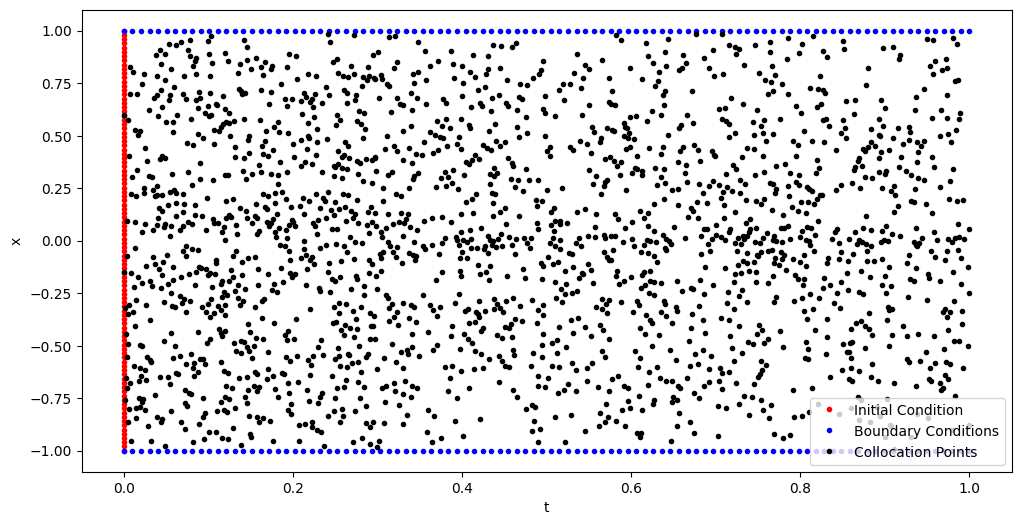

In [11]:
# Plot the initial condition, boundary conditions, and collocation points
plt.figure(figsize=(12, 6))
plt.plot(X0[:, 0], X0[:, 1], 'r.', label='Initial Condition')
plt.plot(Xbc[:, 0], Xbc[:, 1], 'b.', label='Boundary Conditions')
plt.plot(upinn.collocation_points[:, 0].detach(), upinn.collocation_points[:, 1].detach(), 'k.', label='Collocation Points')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()
plt.show()

### Plot Results

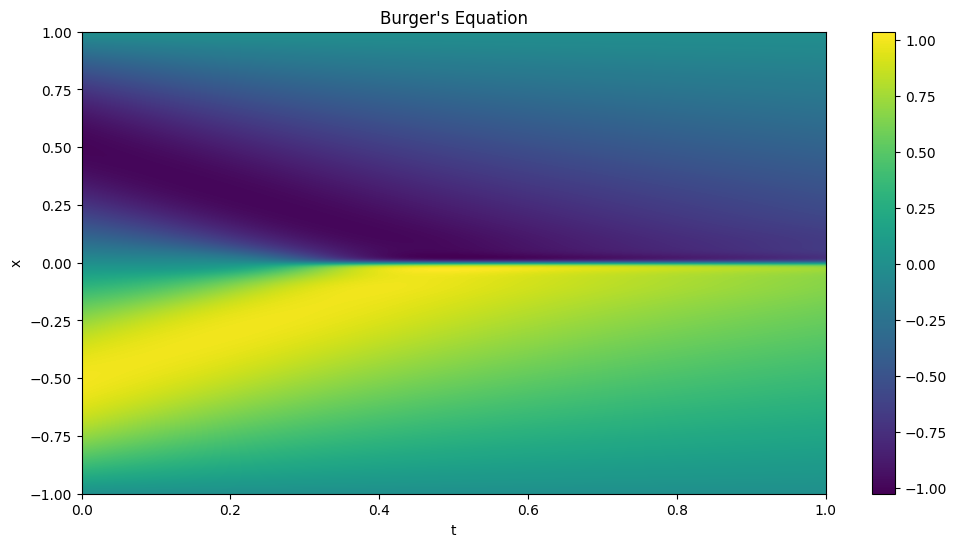

In [12]:
# Make grid
N = 1000
x = torch.linspace(-1, 1, N)
t = torch.linspace(0, 1, N)
X, T = torch.meshgrid(x, t, indexing='ij')
X_star = torch.stack((T.flatten(), X.flatten()), dim=-1)

# Compute the solution
u_star = upinn.predict(X_star)
u = u_star.reshape(N, N).detach().numpy()

# Plot the solution
plt.figure(figsize=(12, 6))
plt.imshow(u, extent=(0, 1, -1, 1), origin='lower', aspect='auto')
plt.colorbar()
plt.xlabel('t')
plt.ylabel('x')
plt.title('Burger\'s Equation')
plt.show()

In [37]:
upinn.G(torch.cat([X_star, u_star], dim=1))

tensor([[-0.0013],
        [-0.0010],
        [-0.0007],
        ...,
        [-0.0003],
        [-0.0003],
        [-0.0003]], grad_fn=<AddmmBackward0>)

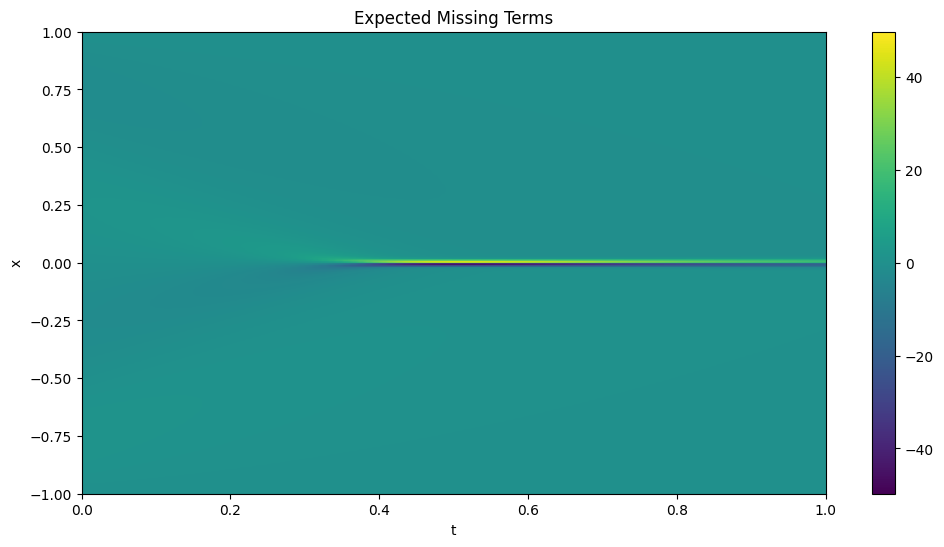

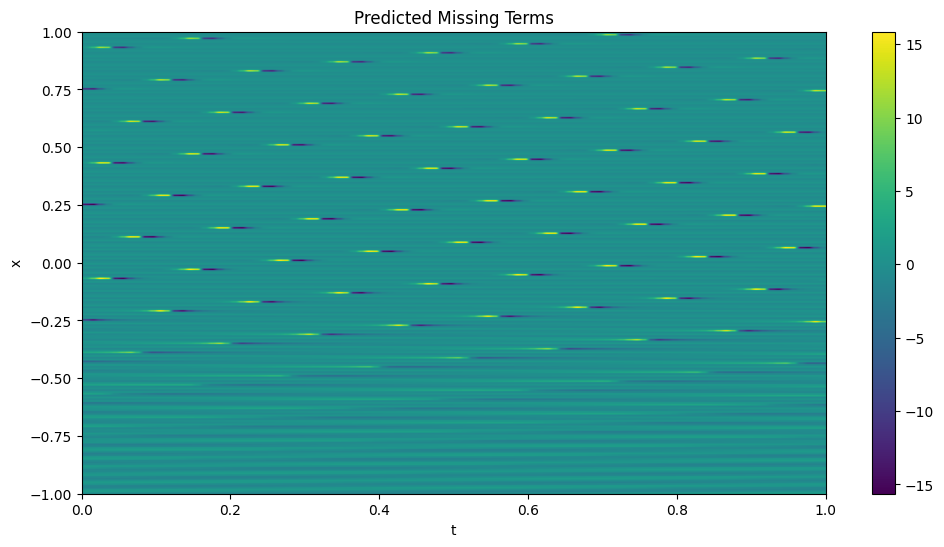

In [40]:
# Plot expected missing terms
U = burger_data['usol']
dUdx = np.gradient(U, burger_data['x'].flatten(), axis=0)

plt.figure(figsize=(12, 6))
plt.imshow(U*dUdx, extent=(0, 1, -1, 1), origin='lower', aspect='auto')
plt.colorbar()
plt.xlabel('t')
plt.ylabel('x')
plt.title('Expected Missing Terms')
plt.show()

# Predicted missing terms
with torch.no_grad():
    u_pred = upinn.predict(Xd)
    res_pred = upinn.G(torch.cat([Xd, u_pred], dim=1))

plt.figure(figsize=(12, 6))
plt.imshow(res_pred.numpy().reshape(*U.shape), extent=(0, 1, -1, 1), origin='lower', aspect='auto')
plt.colorbar()
plt.xlabel('t')
plt.ylabel('x')
plt.title('Predicted Missing Terms')
plt.show()

Make a class that can plot the results of the UPINN.

In [13]:
# Function for refining collocation points based on loss

def collocation_refiner(u_hat, pde_func):
    # Use RAD algorithm to refine collocation points
    N = 1000000
    D = 1000

    x = torch.rand(N, 1, requires_grad=True)*2 - 1    # Random points in [-1, 1]
    t = torch.rand(N, 1, requires_grad=True)
    z = torch.cat([t, x], dim=1)

    # Compute the residual
    u = u_hat(z)
    residual = pde_func(u, z)

    # Sample D points with the largest residual
    residual = residual.detach().numpy()
    
    return z[torch.argsort(residual, descending=True)[:D]]